<a href="https://colab.research.google.com/github/neelabhpaul/Flower_Iris_Classifier/blob/master/AlexNet_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

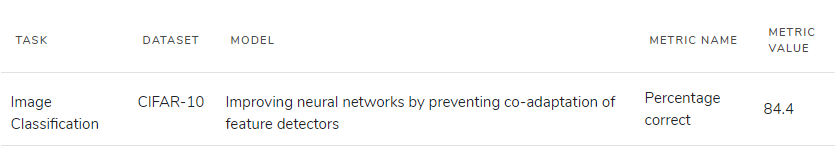

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x  = np.array(test_x)
test_y  = np.array(test_y)

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
train_y.shape

(50000, 1)

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
test_y.shape

(10000, 1)

In [ ]:
# Check for available GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


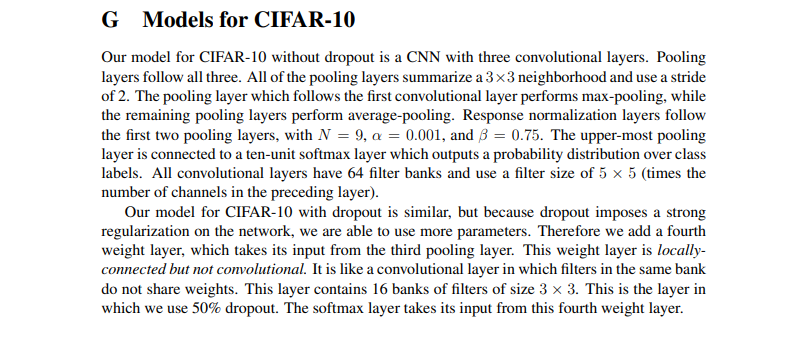

This is a snippet from the paper titled "Improving neural networks by preventing
co-adaptation of feature detectors". Find the paper [here](https://arxiv.org/pdf/1207.0580.pdf).

Modifications that I made while implementing the paper:

- instead of Local response normalization I've used Batch normalization.
- since 0.5 dropout was shutting down necessary neurons too and affecting the accuracy aswell, I used a 0.25 dropout instead.

In [ ]:
def AlexNet(training_images_x, training_images_y):
  with tf.device(device_name):

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(64,(5,5), padding='same',activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(3,2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64,(5,5),padding='same',activation=tf.nn.relu),
        tf.keras.layers.AveragePooling2D(3,2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64,(5,5), padding='same',activation=tf.nn.relu),
        tf.keras.layers.AveragePooling2D(3,2),

        tf.keras.layers.LocallyConnected2D(16,(3,3), strides=(1, 1), padding='valid', activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation = tf.nn.softmax),
        
        ])
    
    def scheduler(epoch):
      if epoch < 60:
        return 0.001
      elif epoch < 70:
        return 0.001/10
      else:
        return 0.001/100

    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    monitor = tf.keras.callbacks.EarlyStopping(
              monitor='accuracy', min_delta=0.0002, patience=5, verbose=1, mode='auto',
              baseline=None, restore_best_weights=False
              )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    history = model.fit(
          training_images_x, training_images_y, epochs = 100, callbacks = [monitor, callback]
     )
    print(model.summary())
    return model


In [ ]:
# One vs all classification
label_binrizer = LabelBinarizer()
train_y = label_binrizer.fit_transform(train_y)
test_y = label_binrizer.fit_transform(test_y)

In [ ]:
train_x = tf.dtypes.cast(train_x, tf.float32)
test_x = tf.dtypes.cast(test_x, tf.float32)

In [ ]:
train_x = train_x/255
test_x = test_x/255

In [ ]:
model = AlexNet(train_x, train_y)

Epoch 1/100
1563/1563 [==============================] - 16s 10ms/step - loss: 2.0116 - accuracy: 0.2543 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.5680 - accuracy: 0.4166 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.3190 - accuracy: 0.5077 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1841 - accuracy: 0.5660 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0691 - accuracy: 0.6167 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9552 - accuracy: 0.6645 - lr: 0.0010
Epoch 7/100
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8710 - accuracy: 0.6980 - lr: 0.0010
Epoch 8/100
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8112 - accuracy: 0.7192 - lr: 0.0010
Epoch 9/100
1563/1563 [==============================] -

In [ ]:
model.evaluate(test_x, test_y, verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 1.4198 - accuracy: 0.8069


[1.4197782278060913, 0.8069000244140625]

In [ ]:
y_pred = model.predict(test_x)

In [ ]:
print('AlexNet test accuracy: ',accuracy_score(test_y, y_pred.round()))

AlexNet test accuracy:  0.8032


In [ ]:
test_y[1552]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])